## Collaborative Filtering on MovieLens 10M dataset
Authors: (USRMODL S12)
- Christopher Lim
- Kyle Kenneth Chua
- Jethro Tsai

## Importing the Libraries

Loading the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Loading the data preparation and model evaluation libraries

In [2]:
from sklearn.model_selection import train_test_split

from mse import mse

## Importing the Datasets

In [3]:
movies = pd.read_csv('./movie.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = pd.read_csv('./rating.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [5]:
df = movies.merge(ratings, how="left", on="movieId")
df.head()

del movies
del ratings

## Exploratory Data Analysis

### Columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000797 entries, 0 to 20000796
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   title      object 
 2   genres     object 
 3   userId     float64
 4   rating     float64
 5   timestamp  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 1.0+ GB


In [7]:
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()
mean_num_ratings = df.groupby('userId').count()['movieId'].mean()

print('Number of users:', n_users)   # 5000
print('Number of movies:', n_movies) # 1000
print('Number of ratings:', len(df))
print('Average number of ratings per user:', mean_num_ratings)

Number of users: 138493
Number of movies: 27278
Number of ratings: 20000797
Average number of ratings per user: 144.4135299257002


<AxesSubplot:xlabel='userId'>

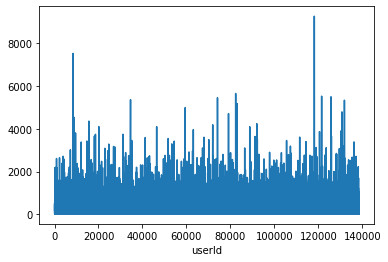

In [8]:
df.groupby('userId').count()['movieId'].plot()

<AxesSubplot:xlabel='movieId'>

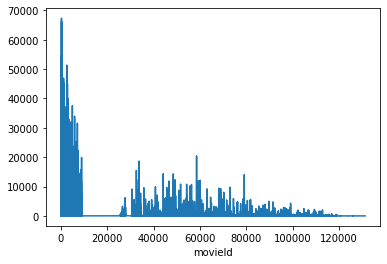

In [9]:
df.groupby('movieId').count()['userId'].plot()

In [10]:
print('Min Rating:', df['rating'].min())
print('Max Rating:', df['rating'].max())

Min Rating: 0.5
Max Rating: 5.0


## Data Preprocessing

### Drop missing user ids

In [11]:
df = df.dropna(subset=["userId"], axis=0)
len(df)

20000263

### Removes `genres`, `timestamp`, and `title` column

In [12]:
# Remove column name 'genres', 'timestamp' and 'title'
df = df.drop(['genres', 'timestamp', 'title'], axis=1)
df['userId'] = df['userId'].astype(int)
df.head()

,movieId,userId,rating
0,1,3,4.0
1,1,6,5.0
2,1,8,4.0
3,1,10,4.0
4,1,11,4.5


### Filter to top 1,000 movies and top 1,000 users

In [13]:
n_users = 1000
n_movies = 1000

In [14]:
titles = df['movieId'].value_counts().head(n_movies).index # top  1,000 most-rated movies
users = df['userId'].value_counts().head(n_users).index  # top 1,000 users with the most number of ratings

top_df = df[(df['movieId'].isin(titles) & df['userId'].isin(users))]
top_df.head()

,movieId,userId,rating
56,1,156,5.0
71,1,208,4.0
123,1,359,5.0
186,1,572,5.0
190,1,586,2.5


In [15]:
print('Number of users:', top_df['userId'].nunique())
print('Number of movies:', top_df['movieId'].nunique()) 
print('Number of ratings:', len(top_df))
print('Average number of ratings per user:', top_df.groupby('userId').count()['movieId'].mean())

Number of users: 1000
Number of movies: 1000
Number of ratings: 627078
Average number of ratings per user: 627.078


#### Convert table format into user-item matrix (utility matrix) format 

In [34]:
top_um= top_df.pivot_table(index=["userId"], columns=["movieId"], values="rating").to_numpy(dtype=np.float32, na_value=0)
sparsity = (1.0 - np.count_nonzero(top_um) / top_um.size) * 100

print('Shape:', top_um.shape)
print('Sparsity: %.2f%%' % sparsity)

Shape: (1000, 1000)
Sparsity: 37.29%


### Filter to top 1,000 movies and 1,000 random users

In [17]:
titles = df['movieId'].value_counts().head(n_movies).index # top  1,000 most-rated movies
users = df.groupby('userId').count().sample(n=n_users, random_state=0).index

random_df = df[df['movieId'].isin(titles)][df['userId'].isin(users)]
random_df.head()

del df

In [18]:
print('Number of users:', random_df['userId'].nunique())
print('Number of movies:', random_df['movieId'].nunique())
print('Number of ratings:', len(random_df))
print('Average number of ratings per user:', random_df.groupby('userId').count()['movieId'].mean())

Number of users: 1000
Number of movies: 1000
Number of ratings: 97366
Average number of ratings per user: 97.366


#### Convert table format into user-item matrix (utility matrix) format 

In [33]:
random_um= random_df.pivot_table(index=["userId"], columns=["movieId"], values="rating").to_numpy(dtype=np.float32, na_value=0)
sparsity = (1.0 - np.count_nonzero(random_um) / random_um.size) * 100

print('Shape:', random_um.shape)
print('Sparsity: %.2f%%' % sparsity)

Shape: (1000, 1000)
Sparsity: 90.26%


### Get MSE on avg rating per user and avg rating per movie

In [35]:
utility_matrices = [top_um, random_um]

for um in utility_matrices:
    average_rating_per_user = [np.mean(row[row > 0]) for row in um]
    print('MSE based on average user rating:', np.sum([np.sum(np.square(row[row > 0] - average_rating_per_user[i])) for i, row in enumerate(um)]) / len(um[um > 0]))
    
    average_rating_per_movie = [np.mean(column[column > 0]) for column in um.T]
    print('MSE based on average movie rating:', np.sum([np.sum(np.square(column[column > 0] - average_rating_per_user[i])) for i, column in enumerate(um.T)]) / len(um[um > 0]))
    
    print('Unique values:', np.unique(um))
    print('-' * 20)

MSE based on average user rating: 0.8692040703070432
MSE based on average movie rating: 1.184244324470002
Unique values: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
--------------------
MSE based on average user rating: 0.8742411846794569
MSE based on average movie rating: 1.2724553809851489
Unique values: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
--------------------


### Convert utility matrix ratings from 0 until 5 to -1 until 1 
[0] values means missing values to be converted to -1  
[0.5, 1, 1.5, 2] values means low ratings to be converted to 0 (labeled as bad ratings)  
[2.5, 3, 3.5, 4, 4.5, 5] values means high ratings to be converted to 1 (labeled as good ratings)

In [36]:
for i, um in enumerate(utility_matrices):
#     um[um == 0] = -1
#     um[(um >= 0) & (um < 2.5)] = 0
#     um[um >= 2.5] = 1
    utility_matrices[i] = um / 5
    
    print(np.unique(utility_matrices[i]))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


## Models

### Matrix Factorization Models

#### Importing the Matrix Factorizatoin Model

In [21]:
from matrix_factorization import MF

#### Training

In [ ]:
hyperparameters = [
    {
        'alpha': 0.005,
        'beta': 0.002,
    },
    {
        'alpha': 0.01,
        'beta': 0.002,
    }
]
training_results = []
predictions = []

for i in range(len(utility_matrices)):
    # Initialize the Matrix Factorization model
    mf = MF(utility_matrices[i], 2, alpha=hyperparameters[i]['alpha'], beta=hyperparameters[i]['beta'], iterations=50)
    
    # Trains the model
    training_result = mf.train()
    
    # Stores the final full matrix
    predictions.append(mf.full_matrix())
    
    # Stores the results
    training_results.append(training_result)

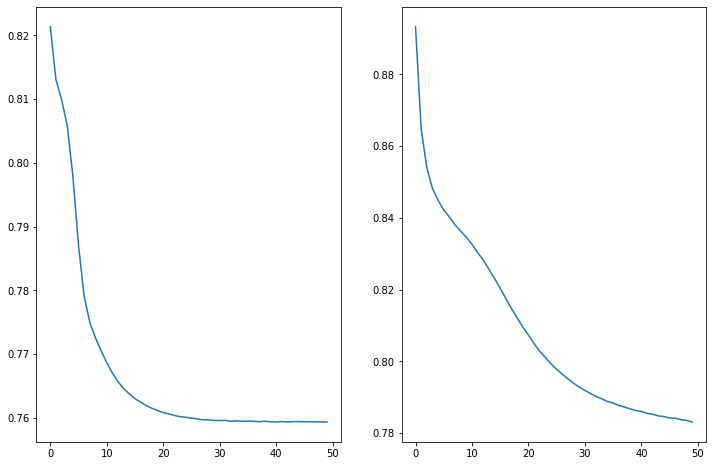

In [30]:
fig = plt.figure(figsize=(8, 12))
titles = ['Top 1,000 Users', '1,000 Random Users']

row = 1
col = 2

for i in range(len(utility_matrices)):
    # Adds a subplot at the 1st position
    fig.add_subplot(row, col, i + 1)
    pd.Series(training_results[i]).plot(logy=False)
    plt.xlabel("Epoch")
    plt.ylabel("RMSE Error")
    plt.title(titles[i])

plt.show()

#### TODO - randomly get a random row/column for each types of data and compare

### Random Boltzmann Machine Models
https://github.com/echen/restricted-boltzmann-machines

#### Importing the RBM Model

In [22]:
from rbm import RBM

Instructions for updating:
non-resource variables are not supported in the long term


#### Training the RBM Model

In [27]:
data = []

for um in utility_matrices:
    # Define the parameters of the RBMs we will train
    rbm=RBM(n_users, n_movies, learning_rate=0.1, epochs=1000, batch_size=200)
    
    # Trains the model
    training_result = rbm.train(um)
    
    output, predicted, _ = rbm.rbm_output(um)
    
    data.append({
        'model': rbm,
        'output': output,
        'predicted': predicted,
        'training_result': training_result
    })

Epoch: 0 ; reconstruction error: 0.328142
Epoch: 1 ; reconstruction error: 0.325087
Epoch: 2 ; reconstruction error: 0.322634
Epoch: 3 ; reconstruction error: 0.321503
Epoch: 4 ; reconstruction error: 0.319847
Epoch: 5 ; reconstruction error: 0.319211
Epoch: 6 ; reconstruction error: 0.318420
Epoch: 7 ; reconstruction error: 0.318199
Epoch: 8 ; reconstruction error: 0.317832
Epoch: 9 ; reconstruction error: 0.317651
Epoch: 10 ; reconstruction error: 0.318186
Epoch: 11 ; reconstruction error: 0.318787
Epoch: 12 ; reconstruction error: 0.319662
Epoch: 13 ; reconstruction error: 0.319045
Epoch: 14 ; reconstruction error: 0.318760
Epoch: 15 ; reconstruction error: 0.319049
Epoch: 16 ; reconstruction error: 0.317776
Epoch: 17 ; reconstruction error: 0.317690
Epoch: 18 ; reconstruction error: 0.317503
Epoch: 19 ; reconstruction error: 0.317535
Epoch: 20 ; reconstruction error: 0.316955
Epoch: 21 ; reconstruction error: 0.316716
Epoch: 22 ; reconstruction error: 0.316482
Epoch: 23 ; reconstru

Epoch: 189 ; reconstruction error: 0.266308
Epoch: 190 ; reconstruction error: 0.266416
Epoch: 191 ; reconstruction error: 0.265483
Epoch: 192 ; reconstruction error: 0.265650
Epoch: 193 ; reconstruction error: 0.266783
Epoch: 194 ; reconstruction error: 0.266608
Epoch: 195 ; reconstruction error: 0.266029
Epoch: 196 ; reconstruction error: 0.265833
Epoch: 197 ; reconstruction error: 0.266694
Epoch: 198 ; reconstruction error: 0.265091
Epoch: 199 ; reconstruction error: 0.266364
Epoch: 200 ; reconstruction error: 0.265628
Epoch: 201 ; reconstruction error: 0.264620
Epoch: 202 ; reconstruction error: 0.264522
Epoch: 203 ; reconstruction error: 0.265900
Epoch: 204 ; reconstruction error: 0.265767
Epoch: 205 ; reconstruction error: 0.265374
Epoch: 206 ; reconstruction error: 0.265059
Epoch: 207 ; reconstruction error: 0.265208
Epoch: 208 ; reconstruction error: 0.264330
Epoch: 209 ; reconstruction error: 0.263521
Epoch: 210 ; reconstruction error: 0.265031
Epoch: 211 ; reconstruction erro

Epoch: 378 ; reconstruction error: 0.252263
Epoch: 379 ; reconstruction error: 0.252177
Epoch: 380 ; reconstruction error: 0.252974
Epoch: 381 ; reconstruction error: 0.251064
Epoch: 382 ; reconstruction error: 0.251312
Epoch: 383 ; reconstruction error: 0.251162
Epoch: 384 ; reconstruction error: 0.250929
Epoch: 385 ; reconstruction error: 0.251965
Epoch: 386 ; reconstruction error: 0.251211
Epoch: 387 ; reconstruction error: 0.250790
Epoch: 388 ; reconstruction error: 0.251966
Epoch: 389 ; reconstruction error: 0.250844
Epoch: 390 ; reconstruction error: 0.251226
Epoch: 391 ; reconstruction error: 0.250639
Epoch: 392 ; reconstruction error: 0.249900
Epoch: 393 ; reconstruction error: 0.250773
Epoch: 394 ; reconstruction error: 0.249131
Epoch: 395 ; reconstruction error: 0.250359
Epoch: 396 ; reconstruction error: 0.250175
Epoch: 397 ; reconstruction error: 0.249775
Epoch: 398 ; reconstruction error: 0.249955
Epoch: 399 ; reconstruction error: 0.249679
Epoch: 400 ; reconstruction erro

Epoch: 566 ; reconstruction error: 0.241810
Epoch: 567 ; reconstruction error: 0.240978
Epoch: 568 ; reconstruction error: 0.241035
Epoch: 569 ; reconstruction error: 0.240759
Epoch: 570 ; reconstruction error: 0.240621
Epoch: 571 ; reconstruction error: 0.241295
Epoch: 572 ; reconstruction error: 0.241010
Epoch: 573 ; reconstruction error: 0.240458
Epoch: 574 ; reconstruction error: 0.240986
Epoch: 575 ; reconstruction error: 0.241727
Epoch: 576 ; reconstruction error: 0.240884
Epoch: 577 ; reconstruction error: 0.240834
Epoch: 578 ; reconstruction error: 0.240719
Epoch: 579 ; reconstruction error: 0.241250
Epoch: 580 ; reconstruction error: 0.240643
Epoch: 581 ; reconstruction error: 0.241168
Epoch: 582 ; reconstruction error: 0.241954
Epoch: 583 ; reconstruction error: 0.240894
Epoch: 584 ; reconstruction error: 0.240634
Epoch: 585 ; reconstruction error: 0.240284
Epoch: 586 ; reconstruction error: 0.240693
Epoch: 587 ; reconstruction error: 0.239792
Epoch: 588 ; reconstruction erro

Epoch: 754 ; reconstruction error: 0.234079
Epoch: 755 ; reconstruction error: 0.234677
Epoch: 756 ; reconstruction error: 0.233613
Epoch: 757 ; reconstruction error: 0.233381
Epoch: 758 ; reconstruction error: 0.234453
Epoch: 759 ; reconstruction error: 0.234187
Epoch: 760 ; reconstruction error: 0.233946
Epoch: 761 ; reconstruction error: 0.234374
Epoch: 762 ; reconstruction error: 0.233478
Epoch: 763 ; reconstruction error: 0.234322
Epoch: 764 ; reconstruction error: 0.232977
Epoch: 765 ; reconstruction error: 0.233595
Epoch: 766 ; reconstruction error: 0.234170
Epoch: 767 ; reconstruction error: 0.233573
Epoch: 768 ; reconstruction error: 0.233461
Epoch: 769 ; reconstruction error: 0.233029
Epoch: 770 ; reconstruction error: 0.233561
Epoch: 771 ; reconstruction error: 0.233112
Epoch: 772 ; reconstruction error: 0.233453
Epoch: 773 ; reconstruction error: 0.233099
Epoch: 774 ; reconstruction error: 0.233106
Epoch: 775 ; reconstruction error: 0.232750
Epoch: 776 ; reconstruction erro

Epoch: 943 ; reconstruction error: 0.228030
Epoch: 944 ; reconstruction error: 0.227948
Epoch: 945 ; reconstruction error: 0.228362
Epoch: 946 ; reconstruction error: 0.228176
Epoch: 947 ; reconstruction error: 0.228645
Epoch: 948 ; reconstruction error: 0.228432
Epoch: 949 ; reconstruction error: 0.228968
Epoch: 950 ; reconstruction error: 0.228108
Epoch: 951 ; reconstruction error: 0.228029
Epoch: 952 ; reconstruction error: 0.228098
Epoch: 953 ; reconstruction error: 0.228382
Epoch: 954 ; reconstruction error: 0.227960
Epoch: 955 ; reconstruction error: 0.228302
Epoch: 956 ; reconstruction error: 0.228416
Epoch: 957 ; reconstruction error: 0.228413
Epoch: 958 ; reconstruction error: 0.228071
Epoch: 959 ; reconstruction error: 0.227846
Epoch: 960 ; reconstruction error: 0.227677
Epoch: 961 ; reconstruction error: 0.227375
Epoch: 962 ; reconstruction error: 0.227925
Epoch: 963 ; reconstruction error: 0.227752
Epoch: 964 ; reconstruction error: 0.227645
Epoch: 965 ; reconstruction erro

Epoch: 133 ; reconstruction error: 0.364223
Epoch: 134 ; reconstruction error: 0.366866
Epoch: 135 ; reconstruction error: 0.363921
Epoch: 136 ; reconstruction error: 0.364461
Epoch: 137 ; reconstruction error: 0.361435
Epoch: 138 ; reconstruction error: 0.361439
Epoch: 139 ; reconstruction error: 0.364360
Epoch: 140 ; reconstruction error: 0.362826
Epoch: 141 ; reconstruction error: 0.360542
Epoch: 142 ; reconstruction error: 0.360977
Epoch: 143 ; reconstruction error: 0.359260
Epoch: 144 ; reconstruction error: 0.360281
Epoch: 145 ; reconstruction error: 0.361382
Epoch: 146 ; reconstruction error: 0.362015
Epoch: 147 ; reconstruction error: 0.358689
Epoch: 148 ; reconstruction error: 0.360745
Epoch: 149 ; reconstruction error: 0.361782
Epoch: 150 ; reconstruction error: 0.360679
Epoch: 151 ; reconstruction error: 0.357576
Epoch: 152 ; reconstruction error: 0.358695
Epoch: 153 ; reconstruction error: 0.357884
Epoch: 154 ; reconstruction error: 0.358623
Epoch: 155 ; reconstruction erro

Epoch: 320 ; reconstruction error: 0.312634
Epoch: 321 ; reconstruction error: 0.312601
Epoch: 322 ; reconstruction error: 0.314542
Epoch: 323 ; reconstruction error: 0.313071
Epoch: 324 ; reconstruction error: 0.312500
Epoch: 325 ; reconstruction error: 0.313710
Epoch: 326 ; reconstruction error: 0.311494
Epoch: 327 ; reconstruction error: 0.311707
Epoch: 328 ; reconstruction error: 0.311925
Epoch: 329 ; reconstruction error: 0.310978
Epoch: 330 ; reconstruction error: 0.312615
Epoch: 331 ; reconstruction error: 0.310255
Epoch: 332 ; reconstruction error: 0.312246
Epoch: 333 ; reconstruction error: 0.309935
Epoch: 334 ; reconstruction error: 0.308041
Epoch: 335 ; reconstruction error: 0.310420
Epoch: 336 ; reconstruction error: 0.311623
Epoch: 337 ; reconstruction error: 0.308982
Epoch: 338 ; reconstruction error: 0.311173
Epoch: 339 ; reconstruction error: 0.308877
Epoch: 340 ; reconstruction error: 0.310237
Epoch: 341 ; reconstruction error: 0.308858
Epoch: 342 ; reconstruction erro

Epoch: 508 ; reconstruction error: 0.275851
Epoch: 509 ; reconstruction error: 0.277178
Epoch: 510 ; reconstruction error: 0.277355
Epoch: 511 ; reconstruction error: 0.275485
Epoch: 512 ; reconstruction error: 0.274863
Epoch: 513 ; reconstruction error: 0.277363
Epoch: 514 ; reconstruction error: 0.276003
Epoch: 515 ; reconstruction error: 0.276508
Epoch: 516 ; reconstruction error: 0.276412
Epoch: 517 ; reconstruction error: 0.275578
Epoch: 518 ; reconstruction error: 0.274074
Epoch: 519 ; reconstruction error: 0.275405
Epoch: 520 ; reconstruction error: 0.276017
Epoch: 521 ; reconstruction error: 0.276200
Epoch: 522 ; reconstruction error: 0.275192
Epoch: 523 ; reconstruction error: 0.274382
Epoch: 524 ; reconstruction error: 0.274873
Epoch: 525 ; reconstruction error: 0.275822
Epoch: 526 ; reconstruction error: 0.275313
Epoch: 527 ; reconstruction error: 0.273947
Epoch: 528 ; reconstruction error: 0.274380
Epoch: 529 ; reconstruction error: 0.273643
Epoch: 530 ; reconstruction erro

Epoch: 697 ; reconstruction error: 0.255990
Epoch: 698 ; reconstruction error: 0.254776
Epoch: 699 ; reconstruction error: 0.254377
Epoch: 700 ; reconstruction error: 0.253687
Epoch: 701 ; reconstruction error: 0.253732
Epoch: 702 ; reconstruction error: 0.254696
Epoch: 703 ; reconstruction error: 0.254714
Epoch: 704 ; reconstruction error: 0.255300
Epoch: 705 ; reconstruction error: 0.253946
Epoch: 706 ; reconstruction error: 0.253901
Epoch: 707 ; reconstruction error: 0.255877
Epoch: 708 ; reconstruction error: 0.252642
Epoch: 709 ; reconstruction error: 0.253449
Epoch: 710 ; reconstruction error: 0.252346
Epoch: 711 ; reconstruction error: 0.252931
Epoch: 712 ; reconstruction error: 0.252646
Epoch: 713 ; reconstruction error: 0.252911
Epoch: 714 ; reconstruction error: 0.255090
Epoch: 715 ; reconstruction error: 0.253726
Epoch: 716 ; reconstruction error: 0.253511
Epoch: 717 ; reconstruction error: 0.253498
Epoch: 718 ; reconstruction error: 0.253048
Epoch: 719 ; reconstruction erro

Epoch: 884 ; reconstruction error: 0.242461
Epoch: 885 ; reconstruction error: 0.241108
Epoch: 886 ; reconstruction error: 0.242336
Epoch: 887 ; reconstruction error: 0.241387
Epoch: 888 ; reconstruction error: 0.240800
Epoch: 889 ; reconstruction error: 0.242344
Epoch: 890 ; reconstruction error: 0.240668
Epoch: 891 ; reconstruction error: 0.242223
Epoch: 892 ; reconstruction error: 0.241962
Epoch: 893 ; reconstruction error: 0.240584
Epoch: 894 ; reconstruction error: 0.241211
Epoch: 895 ; reconstruction error: 0.242270
Epoch: 896 ; reconstruction error: 0.242018
Epoch: 897 ; reconstruction error: 0.241186
Epoch: 898 ; reconstruction error: 0.240619
Epoch: 899 ; reconstruction error: 0.241506
Epoch: 900 ; reconstruction error: 0.238614
Epoch: 901 ; reconstruction error: 0.240750
Epoch: 902 ; reconstruction error: 0.239962
Epoch: 903 ; reconstruction error: 0.240870
Epoch: 904 ; reconstruction error: 0.240553
Epoch: 905 ; reconstruction error: 0.240377
Epoch: 906 ; reconstruction erro

#### Visualization Errors

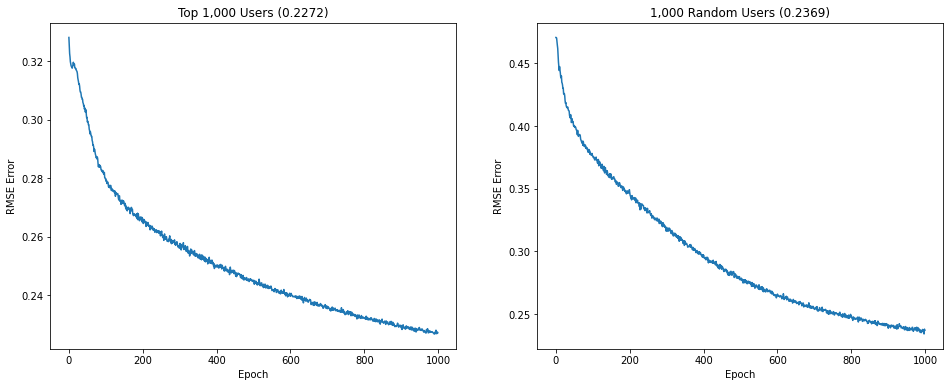

In [28]:
fig = plt.figure(figsize=(16, 6))
titles = ['Top 1,000 Users', '1,000 Random Users']

row = 1
col = 2

for i, d in enumerate(data):
    # Adds a subplot at the 1st position
    fig.add_subplot(row, col, i + 1)
    pd.Series(d['training_result']).plot(logy=False)
    plt.xlabel("Epoch")
    plt.ylabel("RMSE Error")
    plt.title(titles[i] + (' (%.4f)' % (d['training_result'][-1])))

plt.show()

## Results

## Insights and Conclusions